# Libraries

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from time import time
from tqdm.notebook import tqdm

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

# Dense Model

In [2]:
class Linear_Model(nn.Module):
    def __init__(self):
        super(Linear_Model,self).__init__()
        self.fc1 = nn.Linear(784,100) #784 nodes of input and 100 nodes of output
        self.fc2 = nn.Linear(100,10)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=1)
        return x

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
apply_transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root='/content/gdrive/My Drive/Colab Notebooks/data', train=True, download=False, transform=apply_transform)
test_set = datasets.MNIST(root='/content/gdrive/My Drive/Colab Notebooks/data', train=False, download=False, transform=apply_transform)

# Train, Test and Plotting functions

In [6]:
@torch.no_grad()
def get_num_corrects(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [13]:
def train(net, batch_size=256, lr=1e-2, n=50):
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    train_loss_val = []
    train_acc_val = []
    for epoch in tqdm(range(n)):
        tot_loss = 0
        tot_correct = 0
        previous_epoch_timestamp = time()

        for _, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.reshape(-1, 28*28)
            inputs, labels = inputs.to(device), labels.to(device)
            
            preds = net(inputs)
            loss = F.cross_entropy(preds,labels)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            tot_loss += loss.item()
            tot_correct += get_num_corrects(preds,labels)
        train_loss_val.append(tot_loss/(_+1))
        train_acc_val.append(tot_correct/len(train_set)*100)
        if(epoch+1)>(n-6): print(f"lr:{lr} batch_size:{batch_size} epoch: {epoch+1}/{n}, train loss: {train_loss_val[epoch]:.6f}, train accuracy: {train_acc_val[epoch]:.6f}, \
    time Used: {time()-previous_epoch_timestamp:.3f}s")
    return (train_loss_val, train_acc_val)


In [23]:
@torch.no_grad()
def test(net, batch_size=256, lr=1e-2):
    net.eval()
    tot_correct = 0
    tot_loss = 0    
    for _, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.reshape(-1, 28*28)
        inputs, labels = inputs.to(device), labels.to(device)
            
        preds = net(inputs)
        loss = F.cross_entropy(preds,labels)

        tot_loss += loss 
        tot_correct += torch.sum(torch.argmax(preds,dim=1)==labels)
    print(f"lr:{lr} batch_size:{batch_size} testing accuracy: {tot_correct/len(test_set)*100:.6f}  testing loss: {tot_loss/(_+1):.6f}")
    return (tot_loss/(_+1), tot_correct/len(test_set)*100)

In [24]:
def plots(train_loss, train_accuracy, batch_size=256, lr=1e-2, n=50):
    fig = plt.figure(figsize=[15,5])
    fig.suptitle(f'Learning curves with batch_size: {batch_size}, learning_rate: {lr}', fontsize=10)
    plt.subplot(121)
    plt.plot(range(n),train_loss,'r-',label='Loss/error') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.grid(1)
    plt.subplot(122)
    plt.plot(range(n),train_accuracy,'g-',label='Accuracy') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    plt.grid(1)

# Q5 solution

lr:0.01 batch_size:256 epoch: 45/50, train loss: 1.643104, train accuracy: 83.608333,     time Used: 4.703s
lr:0.01 batch_size:256 epoch: 46/50, train loss: 1.641816, train accuracy: 83.688333,     time Used: 4.359s
lr:0.01 batch_size:256 epoch: 47/50, train loss: 1.640268, train accuracy: 83.783333,     time Used: 4.641s
lr:0.01 batch_size:256 epoch: 48/50, train loss: 1.638996, train accuracy: 83.845000,     time Used: 4.715s
lr:0.01 batch_size:256 epoch: 49/50, train loss: 1.637794, train accuracy: 83.903333,     time Used: 4.372s
lr:0.01 batch_size:256 epoch: 50/50, train loss: 1.636836, train accuracy: 83.938333,     time Used: 4.573s

lr:0.01 batch_size:256 testing accuracy: 84.610001  testing loss: 1.630915


(tensor(1.6309, device='cuda:0'), tensor(84.6100, device='cuda:0'))

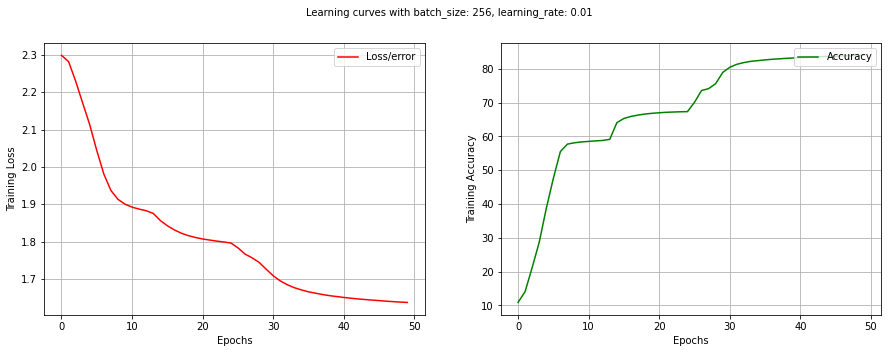

In [10]:
net1 = Linear_Model().to(device)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, num_workers=2)
plots(*train(net1))
test(net1)

# Q6.a solution

In [22]:
def nets_initialize():
    net1 = Linear_Model().to(device)
    net2 = Linear_Model().to(device)
    net3 = Linear_Model().to(device)
    net4 = Linear_Model().to(device)
    net5 = Linear_Model().to(device)
    return (net1,net2,net3,net4,net5)

In [19]:
lrs = [0.5, 0.2, 0.1, 0.05, 0.025]
Batches = [128, 256, 512, 1024]

In [13]:
nets = nets_initialize()
train_losses = []
test_losses = []

In [14]:
for i, Batch in enumerate(Batches):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=Batch, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=Batch, num_workers=4)
    train_losses.append(train(nets[i], batch_size=Batch)[0])
    test_losses.append(test(nets[i], batch_size=Batch)[0])

lr:0.01 batch_size:128 epoch: 45/50, train loss: 1.630870, train accuracy: 84.078333,     time Used: 5.265s
lr:0.01 batch_size:128 epoch: 46/50, train loss: 1.630030, train accuracy: 84.115000,     time Used: 5.342s
lr:0.01 batch_size:128 epoch: 47/50, train loss: 1.629154, train accuracy: 84.178333,     time Used: 5.243s
lr:0.01 batch_size:128 epoch: 48/50, train loss: 1.628327, train accuracy: 84.213333,     time Used: 4.882s
lr:0.01 batch_size:128 epoch: 49/50, train loss: 1.627535, train accuracy: 84.288333,     time Used: 5.108s
lr:0.01 batch_size:128 epoch: 50/50, train loss: 1.626802, train accuracy: 84.313333,     time Used: 5.432s

lr:0.01 batch_size:128 testing accuracy: 84.230003  testing loss: 1.626361


lr:0.01 batch_size:256 epoch: 45/50, train loss: 1.655020, train accuracy: 84.921667,     time Used: 4.487s
lr:0.01 batch_size:256 epoch: 46/50, train loss: 1.634696, train accuracy: 88.580000,     time Used: 4.452s
lr:0.01 batch_size:256 epoch: 47/50, train loss: 1.623343, train accuracy: 89.136667,     time Used: 4.790s
lr:0.01 batch_size:256 epoch: 48/50, train loss: 1.615303, train accuracy: 89.411667,     time Used: 4.667s
lr:0.01 batch_size:256 epoch: 49/50, train loss: 1.608897, train accuracy: 89.671667,     time Used: 4.696s
lr:0.01 batch_size:256 epoch: 50/50, train loss: 1.603772, train accuracy: 89.826667,     time Used: 4.502s

lr:0.01 batch_size:256 testing accuracy: 90.220001  testing loss: 1.596559


lr:0.01 batch_size:512 epoch: 45/50, train loss: 1.692875, train accuracy: 81.241667,     time Used: 4.858s
lr:0.01 batch_size:512 epoch: 46/50, train loss: 1.688465, train accuracy: 81.503333,     time Used: 4.855s
lr:0.01 batch_size:512 epoch: 47/50, train loss: 1.684039, train accuracy: 81.736667,     time Used: 4.775s
lr:0.01 batch_size:512 epoch: 48/50, train loss: 1.680275, train accuracy: 81.948333,     time Used: 4.553s
lr:0.01 batch_size:512 epoch: 49/50, train loss: 1.676798, train accuracy: 82.140000,     time Used: 4.573s
lr:0.01 batch_size:512 epoch: 50/50, train loss: 1.673704, train accuracy: 82.293333,     time Used: 4.310s

lr:0.01 batch_size:512 testing accuracy: 83.000000  testing loss: 1.665929


lr:0.01 batch_size:1024 epoch: 45/50, train loss: 1.844931, train accuracy: 65.763333,     time Used: 4.159s
lr:0.01 batch_size:1024 epoch: 46/50, train loss: 1.841024, train accuracy: 65.868333,     time Used: 4.346s
lr:0.01 batch_size:1024 epoch: 47/50, train loss: 1.837027, train accuracy: 65.968333,     time Used: 4.293s
lr:0.01 batch_size:1024 epoch: 48/50, train loss: 1.833729, train accuracy: 66.073333,     time Used: 4.153s
lr:0.01 batch_size:1024 epoch: 49/50, train loss: 1.830728, train accuracy: 66.125000,     time Used: 4.696s
lr:0.01 batch_size:1024 epoch: 50/50, train loss: 1.827890, train accuracy: 66.240000,     time Used: 4.319s

lr:0.01 batch_size:1024 testing accuracy: 66.799995  testing loss: 1.823500


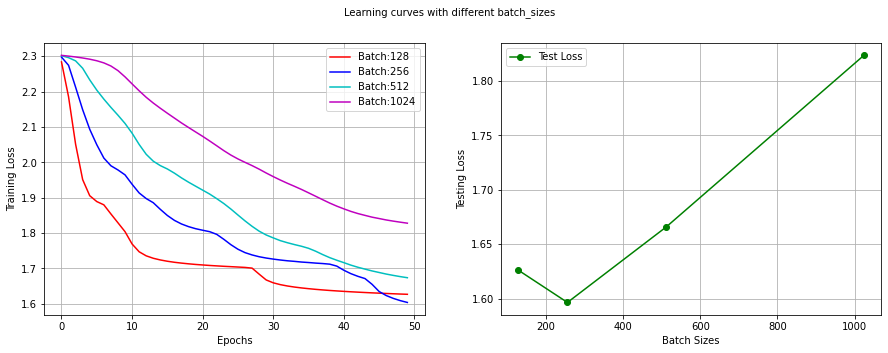

In [15]:
fig = plt.figure(figsize=[15,5])
fig.suptitle(f'Learning curves with different batch_sizes', fontsize=10)
plt.subplot(121)
plt.plot(range(50),train_losses[0],'r-',label='Batch:128') 
plt.plot(range(50),train_losses[1],'b-',label='Batch:256') 
plt.plot(range(50),train_losses[2],'c-',label='Batch:512') 
plt.plot(range(50),train_losses[3],'m-',label='Batch:1024') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(1)
plt.subplot(122)
plt.plot(Batches,test_losses,'g-',label='Test Loss', marker='o') 
plt.legend(loc='upper left')
plt.xlabel('Batch Sizes')
plt.ylabel('Testing Loss')
plt.grid(1)

# Q6.b

In [25]:
nets = nets_initialize()
test_losses_lr = []

In [26]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, num_workers=2)
for i,lr in enumerate(lrs):
    train(nets[i], lr=lr)
    test_losses_lr.append(test(nets[i], lr=lr)[0])

lr:0.5 batch_size:256 epoch: 45/50, train loss: 1.474094, train accuracy: 98.930000,     time Used: 4.759s
lr:0.5 batch_size:256 epoch: 46/50, train loss: 1.473872, train accuracy: 98.953333,     time Used: 4.634s
lr:0.5 batch_size:256 epoch: 47/50, train loss: 1.473608, train accuracy: 98.968333,     time Used: 4.617s
lr:0.5 batch_size:256 epoch: 48/50, train loss: 1.473452, train accuracy: 98.980000,     time Used: 4.597s
lr:0.5 batch_size:256 epoch: 49/50, train loss: 1.473193, train accuracy: 98.998333,     time Used: 4.626s
lr:0.5 batch_size:256 epoch: 50/50, train loss: 1.472959, train accuracy: 99.016667,     time Used: 4.570s

lr:0.5 batch_size:256 testing accuracy: 97.430000  testing loss: 1.488136


lr:0.2 batch_size:256 epoch: 45/50, train loss: 1.486508, train accuracy: 97.980000,     time Used: 4.517s
lr:0.2 batch_size:256 epoch: 46/50, train loss: 1.486037, train accuracy: 98.020000,     time Used: 4.696s
lr:0.2 batch_size:256 epoch: 47/50, train loss: 1.485646, train accuracy: 98.060000,     time Used: 4.580s
lr:0.2 batch_size:256 epoch: 48/50, train loss: 1.485164, train accuracy: 98.090000,     time Used: 4.621s
lr:0.2 batch_size:256 epoch: 49/50, train loss: 1.484849, train accuracy: 98.126667,     time Used: 4.638s
lr:0.2 batch_size:256 epoch: 50/50, train loss: 1.484456, train accuracy: 98.135000,     time Used: 4.583s

lr:0.2 batch_size:256 testing accuracy: 96.949997  testing loss: 1.494496


lr:0.1 batch_size:256 epoch: 45/50, train loss: 1.501660, train accuracy: 96.570000,     time Used: 4.584s
lr:0.1 batch_size:256 epoch: 46/50, train loss: 1.501012, train accuracy: 96.675000,     time Used: 4.530s
lr:0.1 batch_size:256 epoch: 47/50, train loss: 1.500486, train accuracy: 96.696667,     time Used: 4.552s
lr:0.1 batch_size:256 epoch: 48/50, train loss: 1.499830, train accuracy: 96.766667,     time Used: 4.612s
lr:0.1 batch_size:256 epoch: 49/50, train loss: 1.499450, train accuracy: 96.826667,     time Used: 4.705s
lr:0.1 batch_size:256 epoch: 50/50, train loss: 1.498900, train accuracy: 96.855000,     time Used: 4.613s

lr:0.1 batch_size:256 testing accuracy: 96.190002  testing loss: 1.503134


lr:0.05 batch_size:256 epoch: 45/50, train loss: 1.521727, train accuracy: 94.858333,     time Used: 4.618s
lr:0.05 batch_size:256 epoch: 46/50, train loss: 1.520947, train accuracy: 94.926667,     time Used: 4.583s
lr:0.05 batch_size:256 epoch: 47/50, train loss: 1.520135, train accuracy: 95.043333,     time Used: 4.637s
lr:0.05 batch_size:256 epoch: 48/50, train loss: 1.519500, train accuracy: 95.051667,     time Used: 4.649s
lr:0.05 batch_size:256 epoch: 49/50, train loss: 1.519002, train accuracy: 95.101667,     time Used: 4.600s
lr:0.05 batch_size:256 epoch: 50/50, train loss: 1.518243, train accuracy: 95.145000,     time Used: 4.611s

lr:0.05 batch_size:256 testing accuracy: 94.769997  testing loss: 1.519099


lr:0.025 batch_size:256 epoch: 45/50, train loss: 1.550835, train accuracy: 92.496667,     time Used: 4.599s
lr:0.025 batch_size:256 epoch: 46/50, train loss: 1.549435, train accuracy: 92.630000,     time Used: 4.566s
lr:0.025 batch_size:256 epoch: 47/50, train loss: 1.548084, train accuracy: 92.710000,     time Used: 4.602s
lr:0.025 batch_size:256 epoch: 48/50, train loss: 1.546887, train accuracy: 92.808333,     time Used: 4.661s
lr:0.025 batch_size:256 epoch: 49/50, train loss: 1.545847, train accuracy: 92.835000,     time Used: 4.512s
lr:0.025 batch_size:256 epoch: 50/50, train loss: 1.544824, train accuracy: 92.986667,     time Used: 4.620s

lr:0.025 batch_size:256 testing accuracy: 92.769997  testing loss: 1.543455


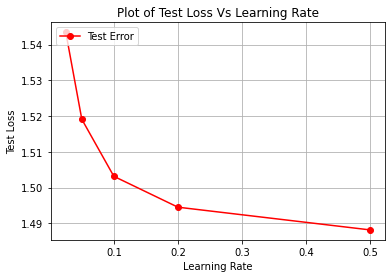

In [27]:
plt.plot(lrs,test_losses_lr, 'r-', label='Test Error', marker='o')
plt.title('Plot of Test Loss Vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.legend(loc='upper left')
plt.grid(1)
plt.show()

**I would prefer learning rate greater than 0.5, as we can see a descent steep in test loss with lr > 0.2. Also for optimum test loss with respect to number of epochs: 50, I prefer 0.5 learning rate (among considered learning rates) which has minimum test loss and maximum test accuracy compared to other learning rates less than 0.2 since they reach minimum (of loss function) much slower than 0.2 .**

# Q6.c solution

In [12]:
net1 = Linear_Model().to(device)
net1.train()
lr = 0.2
n = 50
optimizer = optim.SGD(net1.parameters(), lr=lr, momentum=0.9)
train_loss_val = []
train_acc_val = []
for epoch in tqdm(range(n)):
    tot_loss = 0
    tot_correct = 0
    previous_epoch_timestamp = time()

    if epoch%4 == 0:
      if epoch: lr *= 0.6
    optimizer = optim.SGD(net1.parameters(), lr=lr, momentum=0.9)

    for _, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.reshape(-1, 28*28)
        inputs, labels = inputs.to(device), labels.to(device)
        
        preds = net1(inputs)
        loss = F.cross_entropy(preds,labels)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        tot_loss += loss.item()
        tot_correct += get_num_corrects(preds,labels)
    train_loss_val.append(tot_loss/(_+1))
    train_acc_val.append(tot_correct/len(train_set)*100)
    if(epoch+1)>(n-6): print(f"lr:{lr} batch_size: 256 epoch: {epoch+1}/{n}, train loss: {train_loss_val[epoch]:.6f}, train accuracy: {train_acc_val[epoch]:.6f}, \
    time Used: {time()-previous_epoch_timestamp:.3f}s")

lr:0.0007255941119999997 batch_size: 256 epoch: 45/50, train loss: 1.528227, train accuracy: 94.291667,     time Used: 4.495s
lr:0.0007255941119999997 batch_size: 256 epoch: 46/50, train loss: 1.528151, train accuracy: 94.291667,     time Used: 4.531s
lr:0.0007255941119999997 batch_size: 256 epoch: 47/50, train loss: 1.528090, train accuracy: 94.293333,     time Used: 4.511s
lr:0.0007255941119999997 batch_size: 256 epoch: 48/50, train loss: 1.528081, train accuracy: 94.298333,     time Used: 4.618s
lr:0.00043535646719999985 batch_size: 256 epoch: 49/50, train loss: 1.528145, train accuracy: 94.296667,     time Used: 4.472s
lr:0.00043535646719999985 batch_size: 256 epoch: 50/50, train loss: 1.528028, train accuracy: 94.293333,     time Used: 4.521s



In [15]:
net1.eval()
tot_correct = 0
tot_loss = 0    
for _, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.reshape(-1, 28*28)
    inputs, labels = inputs.to(device), labels.to(device)
        
    preds = net1(inputs)
    loss = F.cross_entropy(preds,labels)

    tot_loss += loss 
    tot_correct += torch.sum(torch.argmax(preds,dim=1)==labels)
print(f'By using SGDR Test Loss: {tot_loss/(_+1):.6f} Test Accuracy: {tot_correct/len(test_set)}')

By using SGDR Test Loss: 1.529074 Test Accuracy: 0.939300000667572


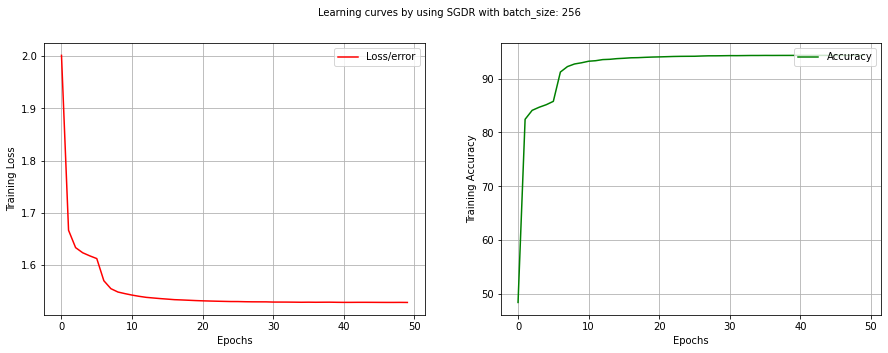

In [16]:
fig = plt.figure(figsize=[15,5])
fig.suptitle(f'Learning curves by using SGDR with batch_size: 256', fontsize=10)
plt.subplot(121)
plt.plot(range(n),train_loss_val,'r-',label='Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.grid(1)
plt.subplot(122)
plt.plot(range(n),train_acc_val,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.grid(1)

**I considered the initial learning rate as 0.2 and reduced by factor 0.6 for every 4 epochs. I observed that the rate of convergence of loss function is way higher than normal training with fixed learning rate. We can also see the plots from solutions of 5 and 6.c which shows a very good picture of differences in rate of convergence of loss functions.**

# END